## Import Modules

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import warnings
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, array_to_img
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

warnings.filterwarnings('ignore')

## Load the files

In [ ]:
BASE_DIR = r"C:\Users\SHAKTHI YAADAV R\Downloads\images"

In [ ]:
target_size = (64, 64)

In [ ]:
# load complete image paths to the list
image_paths = []
for image_name in os.listdir(BASE_DIR):
    image_path = os.path.join(BASE_DIR, image_name)
    image_paths.append(image_path)

In [ ]:
len(image_paths)

63565

## Visualize the Image Dataset

In [ ]:
# to display grid of images (7x7)
plt.figure(figsize=(20, 20))
temp_images = image_paths[:49]
index = 1

for image_path in temp_images:
    plt.subplot(7, 7, index)
    # load the image
    img = load_img(image_path)
    # convert to numpy array
    img = np.array(img)
    # show the image
    plt.imshow(img)
    plt.axis('off')
    # increment the index for next image
    index += 1

## Preprocess Images

In [ ]:
train_images = []
for path in tqdm(image_paths):
    img = load_img(path, target_size=target_size)
    img_array = np.array(img)
    train_images.append(img_array)

  0%|          | 0/63565 [00:00<?, ?it/s]

In [ ]:
train_images[0].shape

(64, 64, 3)

In [ ]:
# reshape the array
import numpy as np

# Convert the list of arrays into a NumPy array
train_images = np.array(train_images)

# Reshape the array
train_images = train_images.reshape(train_images.shape[0], 64, 64, 3).astype('float32')


In [ ]:
# normalize the images
train_images = (train_images - 127.5) / 127.5

In [ ]:
train_images[0]

## Create Generator & Discriminator Models

In [ ]:
# latent dimension for random noise
LATENT_DIM = 100
# weight initializer
WEIGHT_INIT = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
# no. of channels of the image
CHANNELS = 3 # for gray scale, keep it as 1

### Generator Model

Generator Model will create new images similar to training data from random noise

In [ ]:
model = Sequential(name='generator')

# 1d random noise
model.add(layers.Dense(8 * 8 * 512, input_dim=LATENT_DIM))
# model.add(layers.BatchNormalization())
model.add(layers.ReLU())

# convert 1d to 3d
model.add(layers.Reshape((8, 8, 512)))

# upsample to 16x16
model.add(layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same', kernel_initializer=WEIGHT_INIT))
# model.add(layers.BatchNormalization())
model.add(layers.ReLU())

# upsample to 32x32
model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', kernel_initializer=WEIGHT_INIT))
# model.add(layers.BatchNormalization())
model.add(layers.ReLU())

# upsample to 64x64
model.add(layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', kernel_initializer=WEIGHT_INIT))
# model.add(layers.BatchNormalization())
model.add(layers.ReLU())

model.add(layers.Conv2D(CHANNELS, (4, 4), padding='same', activation='tanh'))

generator = model
generator.summary()

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 32768)               │       3,309,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 16, 16, 256)         │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 32, 32, 128)         │         524,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 64, 64, 64)          │         131,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_3 (ReLU)                       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 64, 64, 3)           │           3,075 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,065,603 (23.14 MB)

 Trainable params: 6,065,603 (23.14 MB)

 Non-trainable params: 0 (0.00 B)

### Discriminator Model

Discriminator model will classify the image from the generator to check whether it real (or) fake images.

In [ ]:
model = Sequential(name='discriminator')
input_shape = (64, 64, 3)
alpha = 0.2

# create conv layers
model.add(layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', input_shape=input_shape))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU(alpha=alpha))

model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same', input_shape=input_shape))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU(alpha=alpha))

model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same', input_shape=input_shape))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU(alpha=alpha))

model.add(layers.Flatten())
model.add(layers.Dropout(0.3))

# output class
model.add(layers.Dense(1, activation='sigmoid'))

discriminator = model
discriminator.summary()

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 8, 8, 128)           │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │           8,193 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 406,081 (1.55 MB)

 Trainable params: 405,441 (1.55 MB)

 Non-trainable params: 640 (2.50 KB)

## Create DCGAN

In [ ]:
class DCGAN(keras.Model):
    def __init__(self, generator, discriminator, latent_dim):
        super().__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.latent_dim = latent_dim
        self.g_loss_metric = keras.metrics.Mean(name='g_loss')
        self.d_loss_metric = keras.metrics.Mean(name='d_loss')

    @property
    def metrics(self):
        return [self.g_loss_metric, self.d_loss_metric]

    def compile(self, g_optimizer, d_optimizer, loss_fn):
        super(DCGAN, self).compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):
        # get batch size from the data
        batch_size = tf.shape(real_images)[0]
        # generate random noise
        random_noise = tf.random.normal(shape=(batch_size, self.latent_dim))

        # train the discriminator with real (1) and fake (0) images
        with tf.GradientTape() as tape:
            # compute loss on real images
            pred_real = self.discriminator(real_images, training=True)
            # generate real image labels
            real_labels = tf.ones((batch_size, 1))
            # label smoothing
            real_labels += 0.05 * tf.random.uniform(tf.shape(real_labels))
            d_loss_real = self.loss_fn(real_labels, pred_real)

            # compute loss on fake images
            fake_images = self.generator(random_noise)
            pred_fake = self.discriminator(fake_images, training=True)
            # generate fake labels
            fake_labels = tf.zeros((batch_size, 1))
            d_loss_fake = self.loss_fn(fake_labels, pred_fake)

            # total discriminator loss
            d_loss = (d_loss_real + d_loss_fake) / 2

        # compute discriminator gradients
        gradients = tape.gradient(d_loss, self.discriminator.trainable_variables)
        # update the gradients
        self.d_optimizer.apply_gradients(zip(gradients, self.discriminator.trainable_variables))


        # train the generator model
        labels = tf.ones((batch_size, 1))
        # generator want discriminator to think that fake images are real
        with tf.GradientTape() as tape:
            # generate fake images from generator
            fake_images = self.generator(random_noise, training=True)
            # classify images as real or fake
            pred_fake = self.discriminator(fake_images, training=True)
            # compute loss
            g_loss = self.loss_fn(labels, pred_fake)

        # compute gradients
        gradients = tape.gradient(g_loss, self.generator.trainable_variables)
        # update the gradients
        self.g_optimizer.apply_gradients(zip(gradients, self.generator.trainable_variables))

        # update states for both models
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {'d_loss': self.d_loss_metric.result(), 'g_loss': self.g_loss_metric.result()}

In [ ]:
class DCGANMonitor(keras.callbacks.Callback):
    def __init__(self, num_imgs=25, latent_dim=100):
        self.num_imgs = num_imgs
        self.latent_dim = latent_dim
        # create random noise for generating images
        self.noise = tf.random.normal([25, latent_dim])

    def on_epoch_end(self, epoch, logs=None):
        # generate the image from noise
        g_img = self.model.generator(self.noise)
        # denormalize the image
        g_img = (g_img * 127.5) + 127.5
        g_img.numpy()

        fig = plt.figure(figsize=(8, 8))
        for i in range(self.num_imgs):
            plt.subplot(5, 5, i+1)
            img = array_to_img(g_img[i])
            plt.imshow(img)
            plt.axis('off')
        # plt.savefig('epoch_{:03d}.png'.format(epoch))
        plt.show()

    def on_train_end(self, logs=None):
        self.model.generator.save('generator.h5')

In [ ]:
dcgan = DCGAN(generator=generator, discriminator=discriminator, latent_dim=LATENT_DIM)

In [ ]:
D_LR = 0.0001
G_LR = 0.0003
dcgan.compile(g_optimizer=Adam(learning_rate=G_LR, beta_1=0.5), d_optimizer=Adam(learning_rate=D_LR, beta_1=0.5), loss_fn=BinaryCrossentropy())

In [ ]:
N_EPOCHS = 30
# Increase batch size
BATCH_SIZE = 32
# Define optimizer and loss function
g_optimizer = tf.keras.optimizers.Adam(learning_rate=G_LR, beta_1=0.5)
d_optimizer = tf.keras.optimizers.Adam(learning_rate=D_LR, beta_1=0.5)
loss_fn = tf.keras.losses.BinaryCrossentropy()

# Compile and train the model
dcgan.compile(g_optimizer=g_optimizer, d_optimizer=d_optimizer, loss_fn=loss_fn)
dcgan.fit(train_images, epochs=N_EPOCHS, batch_size=BATCH_SIZE, callbacks=[DCGANMonitor()])


## Generate Single New Anime Image

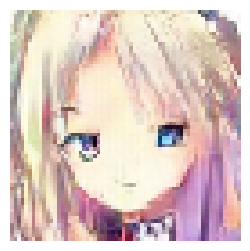

In [ ]:
noise = tf.random.normal([1, 100])
fig = plt.figure(figsize=(3, 3))
# generate the image from noise
g_img = dcgan.generator(noise)
# denormalize the image
g_img = (g_img * 127.5) + 127.5
g_img.numpy()
img = array_to_img(g_img[0])
plt.imshow(img)
plt.axis('off')
# plt.savefig('epoch_{:03d}.png'.format(epoch))
plt.show()

# Generate 20 Output Images

In [ ]:
# Import necessary libraries
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import array_to_img
import os

# Create a directory to save the generated images if it doesn't exist
output_dir = 'generated_images'
os.makedirs(output_dir, exist_ok=True)

# Define the number of images to generate
num_images_to_generate = 20

# Loop over epochs
for epoch in range(N_EPOCHS):
    # Generate random noise for multiple images
    noise = tf.random.normal([num_images_to_generate, LATENT_DIM])

    # Generate images from the noise using the generator model
    generated_images = dcgan.generator(noise)

    # Denormalize the generated images
    generated_images = (generated_images * 127.5) + 127.5

    # Plot and save the generated images
    plt.figure(figsize=(10, 10))
    for i in range(num_images_to_generate):
        plt.subplot(4, 5, i+1)
        img = array_to_img(generated_images[i])
        plt.imshow(img)
        plt.axis('off')

        # Save the image to the output directory
        img.save(os.path.join(output_dir, f'epoch_{epoch}_image_{i}.png'))

    # Save the figure with generated images
    plt.savefig(os.path.join(output_dir, f'epoch_{epoch}_collage.png'))
    plt.show()


## line graph showing the loss of a generator and a discriminator over a set number of epochs

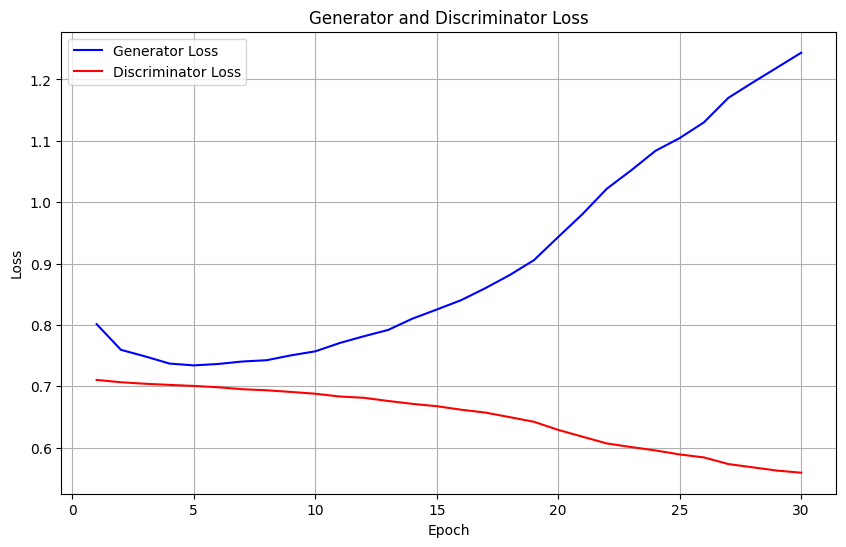

In [ ]:
import matplotlib.pyplot as plt
import os

# Create a directory to save the output if it doesn't exist
output_dir = 'output'
os.makedirs(output_dir, exist_ok=True)

# Extract generator and discriminator loss history
g_losses = dcgan.history.history['g_loss']
d_losses = dcgan.history.history['d_loss']

# Plot the loss curves
plt.figure(figsize=(10, 6))
epochs = range(1, len(g_losses) + 1)
plt.plot(epochs, g_losses, label='Generator Loss', color='blue')
plt.plot(epochs, d_losses, label='Discriminator Loss', color='red')
plt.title('Generator and Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Save the plot to the output directory
plt.savefig(os.path.join(output_dir, 'loss_curve.png'))

# Display the plot
plt.show()


## line graph showing the FID Score of a model improving over training epochs.░

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import sqrtm
from tensorflow.keras.applications import inception_v3
from tensorflow.image import resize  # Importing resize from TensorFlow's image module

# Path to the output directory for saving plots
output_dir = 'output'

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Calculate the FID score between two sets of images
def calculate_fid_score(real_images, generated_images):
    # Resize images to 299x299 as required by InceptionV3
    real_resized = resize(real_images, [299, 299])  # Resize real images
    generated_resized = resize(generated_images, [299, 299])  # Resize generated images

    # Preprocess images for InceptionV3
    real_preprocessed = inception_v3.preprocess_input(real_resized)
    generated_preprocessed = inception_v3.preprocess_input(generated_resized)

    # Load InceptionV3 model
    model = inception_v3.InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))

    # Extract features from real and generated images
    real_features = model.predict(real_preprocessed)
    generated_features = model.predict(generated_preprocessed)

    # Calculate mean and covariance of features
    mu_real, sigma_real = np.mean(real_features, axis=0), np.cov(real_features, rowvar=False)
    mu_generated, sigma_generated = np.mean(generated_features, axis=0), np.cov(generated_features, rowvar=False)

    # Calculate FID score
    fid = np.sum((mu_real - mu_generated)**2) + np.trace(sigma_real + sigma_generated - 2*sqrtm(np.dot(sigma_real, sigma_generated)))

    return fid

# Generate images using the trained generator
num_generated_images = 100  # Adjust as needed
noise = tf.random.normal([num_generated_images, LATENT_DIM])
generated_images = dcgan.generator(noise, training=False)

# Calculate FID score between real and generated images
fid_score = calculate_fid_score(train_images[:num_generated_images], generated_images)

# Plot the FID score as a line graph
plt.figure(figsize=(10, 6))
plt.plot([0, 1], [fid_score, fid_score], 'r--', label='FID Score: {:.2f}'.format(fid_score))
plt.title('FID Score Over Training Epochs')
plt.xlabel('Epoch')
plt.ylabel('FID Score')
plt.legend()
plt.grid(True)

# Save the plot to the output directory
plt.savefig(os.path.join(output_dir, 'fid_score_curve.png'))

# Display the plot
plt.show()
